In [1]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5

In [2]:
path = 'araña.txt'
text = open(path, 'r', encoding='utf-8').read().replace('\n', ' ').lower()
print('corpus length:', len(text))

corpus length: 351052


In [3]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
print(f'unique chars: {len(chars)}')

unique chars: 59


In [4]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(f'num training examples: {len(sentences)}')

num training examples: 117004


In [5]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [6]:
sentences[100]

' de seda, como queriendo medir con justo'

In [7]:
next_chars[100]

' '

In [8]:
X[0][0]

array([False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [9]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [10]:
X.shape

(117004, 40, 59)

In [11]:
y.shape

(117004, 59)

In [12]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

In [13]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [14]:
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Epoch 1/20
869/869 [==============================] - 221s 181ms/step - loss: 2.3651 - accuracy: 0.3078 - val_loss: 1.8435 - val_accuracy: 0.4464
Epoch 2/20
869/869 [==============================] - 153s 176ms/step - loss: 1.7328 - accuracy: 0.4738 - val_loss: 1.6702 - val_accuracy: 0.5011
Epoch 3/20
869/869 [==============================] - 156s 180ms/step - loss: 1.5650 - accuracy: 0.5244 - val_loss: 1.5879 - val_accuracy: 0.5250
Epoch 4/20
869/869 [==============================] - 154s 177ms/step - loss: 1.4749 - accuracy: 0.5518 - val_loss: 1.5675 - val_accuracy: 0.5334
Epoch 5/20
869/869 [==============================] - 160s 185ms/step - loss: 1.4163 - accuracy: 0.5638 - val_loss: 1.5374 - val_accuracy: 0.5385
Epoch 6/20
869/869 [==============================] - 152s 175ms/step - loss: 1.3744 - accuracy: 0.5775 - val_loss: 1.5413 - val_accuracy: 0.5445
Epoch 7/20
869/869 [==============================] - 151s 174ms/step - loss: 1.3436 - accuracy: 0.5846 - val_loss: 1.5367 -

In [15]:
model.save('keras_model_char.h5')
pickle.dump(history, open("history.p", "wb"))

In [17]:
model = load_model('keras_model_char.h5')
history = pickle.load(open("history.p", "rb"))

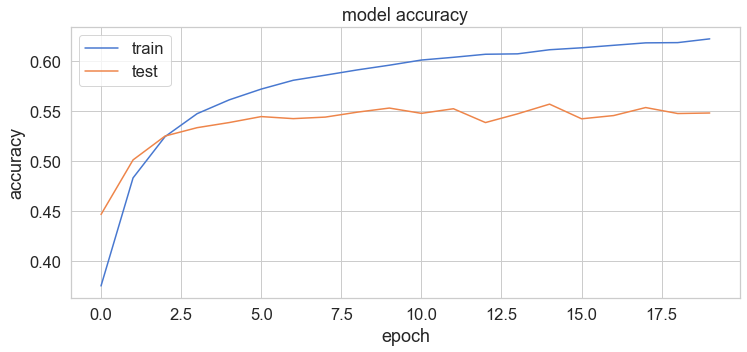

In [21]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

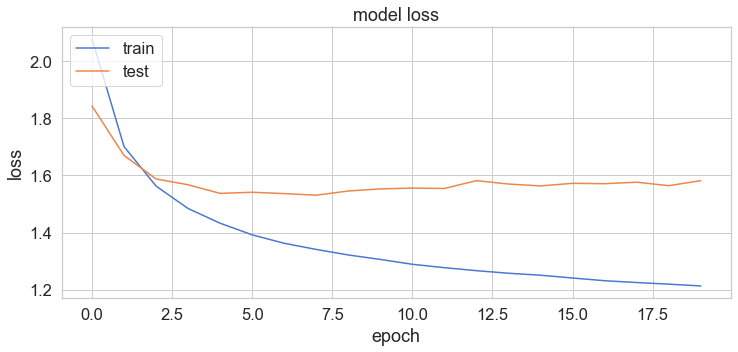

In [22]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [23]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
    return x

In [25]:
prepare_input("This is an example of input for our LSTM".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [26]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [27]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [28]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [32]:
quotes = [
    "El brutal encuentro duró sólo algunos instantes.",
    "Para eso había entrado él en la Guardia Real.",
    "Con qué elocuencia sabía hablar a sus compañeros para decidirles a que desenvainaran su espada contra el Gobierno",
    "Cuatro batallones de la Guardia Real salieron aquella misma noche de Madrid, mandados por oficiales jóvenes y de poca graduación, pues el que más, era capitán.",
    "Se esperaban graves acontecimientos para dentro de breves horas."
]

In [33]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

el brutal encuentro duró sólo algunos in
['stantes, ', 'ficantes, ', 'corrementes ', 'teresas ', 'mediatamente ']

para eso había entrado él en la guardia 
['de ', 'y ', 'había ', 'con ', 'en ']

con qué elocuencia sabía hablar a sus co
['ndesitos ', 'mpasios, ', 'sas ', 'rtes ', 'legios, ']

cuatro batallones de la guardia real sal
['ientes ', 'de ', 'ían ', ' de ', 'go ']

se esperaban graves acontecimientos para
[' estar ', 's ', 'ndones ', 'dos ', 'ces ']

